Load pipeline

In [7]:
from diffusers import DiffusionPipeline
model_id = "yahoo-inc/photo-background-generation"
pipeline = DiffusionPipeline.from_pretrained(model_id, custom_pipeline=model_id)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
pipeline = pipeline.to('cuda')

In [9]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("cpu")
print(f"Device: {device}, {use_cuda}")

Device: cuda, True


Load an image and extract its background and foreground

In [10]:
from PIL import Image, ImageOps
import requests
from io import BytesIO
from transparent_background import Remover

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

seed = 0
# image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Granja_comary_Cisne_-_Escalavrado_e_Dedo_De_Deus_ao_fundo_-Teres%C3%B3polis.jpg/2560px-Granja_comary_Cisne_-_Escalavrado_e_Dedo_De_Deus_ao_fundo_-Teres%C3%B3polis.jpg'
# image_url = 'https://drive.google.com/drive/u/0/folders/1VDCasP94xBVLd_WE1AVNgsjd18tBzxBG/Granja_comary_Cisne_-_Escalavrado_e_Dedo_De_Deus_ao_fundo_-Teres%C3%B3polis.jpg'
# response = requests.get(image_url)
# print(response)
# print(response.content)
# img = Image.open(BytesIO(content))

# read an image from bat.jpg
img = Image.open('bat.jpg')
img = resize_with_padding(img, (512, 512))
print(img)

# Load background detection model
remover = Remover() # default setting
remover = Remover(mode='base') # nightly release checkpoint

# Get foreground mask
fg_mask = remover.process(img, type='map') # default setting - transparent background

<PIL.Image.Image image mode=RGB size=512x512 at 0x26EBFEB6990>
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


Background generation

C:\Users\sasha\anaconda3\envs\DS-study\Lib\site-packages\diffusers\models\attention_processor.py:1406: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


  0%|          | 0/20 [00:00<?, ?it/s]

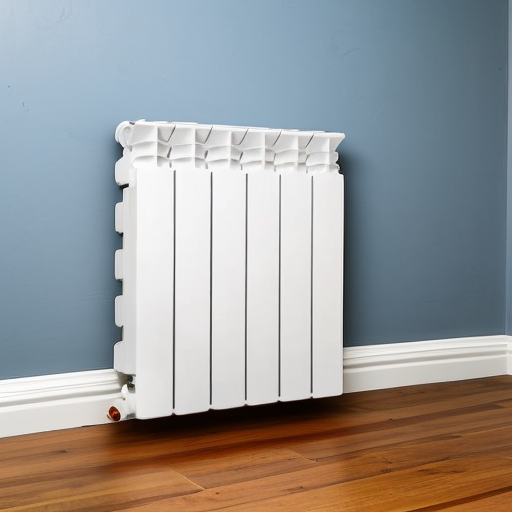

In [11]:
seed = 5
mask = ImageOps.invert(fg_mask)
img = resize_with_padding(img, (512, 512))
generator = torch.Generator(device='cuda').manual_seed(seed)
# prompt = 'A dark swan on a beach'
prompt = 'A radiator in the living room with grey-blue walls'
cond_scale = 1.0
with torch.autocast("cuda"):
    controlnet_image = pipeline(
        prompt=prompt, image=img, mask_image=mask, control_image=mask, num_images_per_prompt=1, generator=generator, num_inference_steps=20, guess_mode=False, controlnet_conditioning_scale=cond_scale
    ).images[0]
controlnet_image
